## Start off with key imports and enforcement of rcparams

In [31]:
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import os
import lightkurve as lk
from astropy.io import ascii
from astropy.table import Table
from astropy.time import Time
import astropy.units as u

os.chdir(pathlib.Path.cwd())
def set_rcparams():
    tab = Table.read('../../rcparams.txt', format='csv')
    for i in range(len(tab)):
        try:
            plt.rcParams[tab['key'][i]] = float(tab['val'][i])
        except ValueError:
            plt.rcParams[tab['key'][i]] = str(tab['val'][i])
    return
set_rcparams()

In [35]:
gp = pd.read_csv('/Users/mschochet/Documents/GitHub/au_mic_s25/folded_lcs/gp.csv')
ip = pd.read_csv('/Users/mschochet/Documents/GitHub/au_mic_s25/folded_lcs/ip.csv')
rp = pd.read_csv('/Users/mschochet/Documents/GitHub/au_mic_s25/folded_lcs/rp.csv')
U = pd.read_csv('/Users/mschochet/Documents/GitHub/au_mic_s25/folded_lcs/U.csv')
B = pd.read_csv('/Users/mschochet/Documents/GitHub/au_mic_s25/folded_lcs/B.csv')
V = pd.read_csv('/Users/mschochet/Documents/GitHub/au_mic_s25/folded_lcs/V.csv')


In [41]:
gp_lc[gp_lc['time']]#>0.5]## > 0.5*u.daygp_lc

ValueError: Illegal type <class 'astropy.time.core.Time'> for table item access

In [44]:
gp_lc = lk.LightCurve(time=gp['time'], flux=gp['flux'], flux_err=gp['flux_err'])
rp_lc = lk.LightCurve(time=rp['time'], flux=rp['flux'], flux_err=rp['flux_err'])
ip_lc = lk.LightCurve(time=ip['time'], flux=ip['flux'], flux_err=ip['flux_err'])
U_lc = lk.LightCurve(time=U['time'], flux=U['flux'], flux_err=U['flux_err'])
B_lc = lk.LightCurve(time=B['time'], flux=B['flux'], flux_err=B['flux_err'])
V_lc = lk.LightCurve(time=V['time'], flux=V['flux'], flux_err=V['flux_err'])


gp_lc /= np.median(gp_lc[(gp_lc['time'].value > 0.5) &  (gp_lc['time'].value < 1.0)]['flux'])
ip_lc /= np.median(ip_lc[(ip_lc['time'].value > 0.5) &  (ip_lc['time'].value < 1.0)]['flux'])
rp_lc /= np.median(rp_lc[(rp_lc['time'].value > 0.5) &  (rp_lc['time'].value < 1.0)]['flux'])
U_lc /= np.median(U_lc[(U_lc['time'].value > 0.5) &  (U_lc['time'].value < 1.0)]['flux'])
B_lc /= np.median(B_lc[(B_lc['time'].value > 0.5) &  (B_lc['time'].value < 1.0)]['flux'])
V_lc /= np.median(V_lc[(V_lc['time'].value > 0.5) &  (V_lc['time'].value < 1.0)]['flux'])

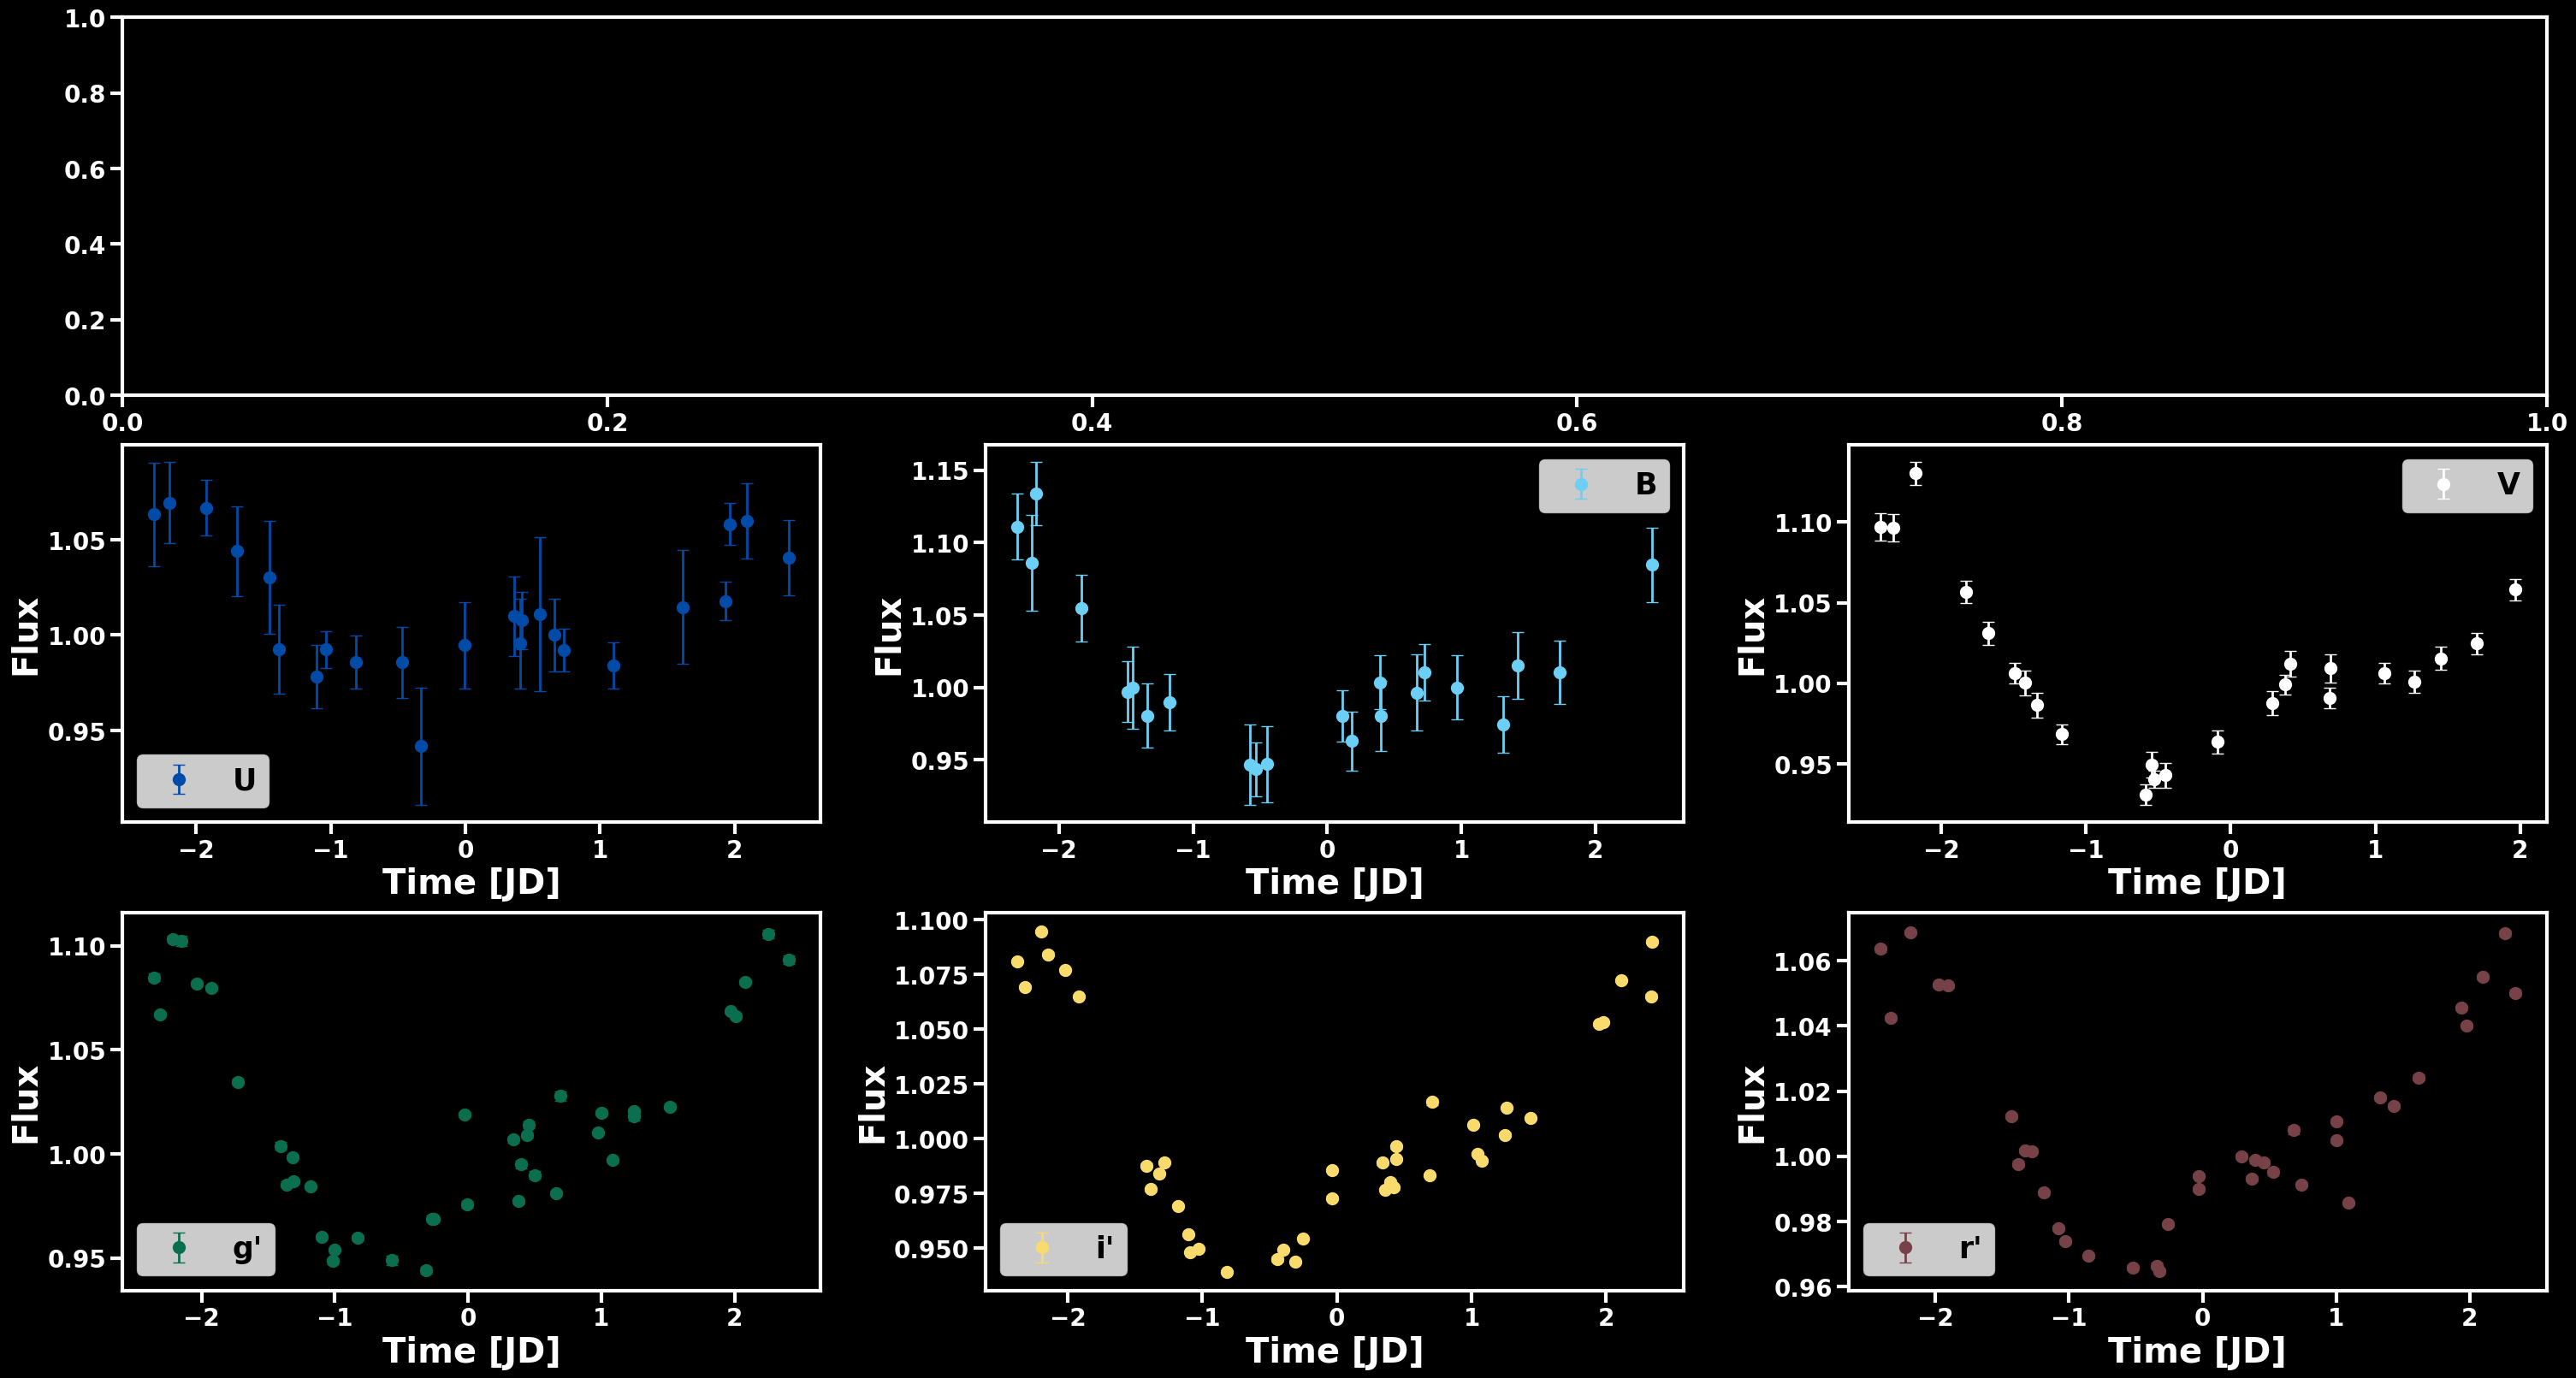

In [55]:
import matplotlib.gridspec as gridspec

plt.style.use('dark_background')
fig = plt.figure(constrained_layout=True, figsize=(30, 16))
spec = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
ax1 = fig.add_subplot(spec[0, :])
ax2 = fig.add_subplot(spec[1, 0])
ax3 = fig.add_subplot(spec[1, 1])
ax4 = fig.add_subplot(spec[1, 2])
ax5 = fig.add_subplot(spec[2, 0])
ax6 = fig.add_subplot(spec[2, 1])
ax7 = fig.add_subplot(spec[2, 2])


U_lc.errorbar(ax=ax2, markersize=10, fmt='o', elinewidth=2, capsize=5, label='U', c="#004BA8")
B_lc.errorbar(ax=ax3, markersize=10, fmt='o', elinewidth=2, capsize=5, label='B' , c="#6CCFF6")
V_lc.errorbar(ax=ax4, markersize=10, fmt='o', elinewidth=2, capsize=5, label='V' , c="#FFFFFF")

gp_lc.errorbar(ax=ax5, markersize=10, fmt='o', elinewidth=2, capsize=5, label='g\'', c='#0B6E4F')
rp_lc.errorbar(ax=ax6, markersize=10, fmt='o', elinewidth=2, capsize=5, label='i\'', c='#F9DB6D')
ip_lc.errorbar(ax=ax7, markersize=10, fmt='o', elinewidth=2, capsize=5, label='r\'', c='#764248')

ax2.legend(fontsize=25, facecolor='w', labelcolor='k')
ax3.legend(fontsize=25, facecolor='w', labelcolor='k')
ax4.legend(fontsize=25, facecolor='w', labelcolor='k')
ax5.legend(fontsize=25, facecolor='w', labelcolor='k')
ax6.legend(fontsize=25, facecolor='w', labelcolor='k')
ax7.legend(fontsize=25, facecolor='w', labelcolor='k')